In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchdiffeq
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel
from torch.utils.data import DataLoader

savedir = "models/ear"
os.makedirs(savedir, exist_ok=True)

/users/darun/.conda/envs/ft/lib/python3.10/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 10


# Define transformations (resize and normalization)
transform = transforms.Compose([
    transforms.Resize((128, 128)),          # Resize to 128x128
    transforms.ToTensor(),                  # Convert images to tensor with shape [3, 128, 128]
    transforms.Normalize((0.5, 0.5, 0.5),   # Normalize each RGB channel
                         (0.5, 0.5, 0.5))
])

# Load dataset using ImageFolder
trainset = datasets.ImageFolder(
    root="/store01/flynn/darun/awe/",  # Path to your main data folder (my_data)
    transform=transform      # Apply transformations
)


train_loader = DataLoader(trainset, batch_size=32, shuffle=True)


torch.Size([3, 128, 128])


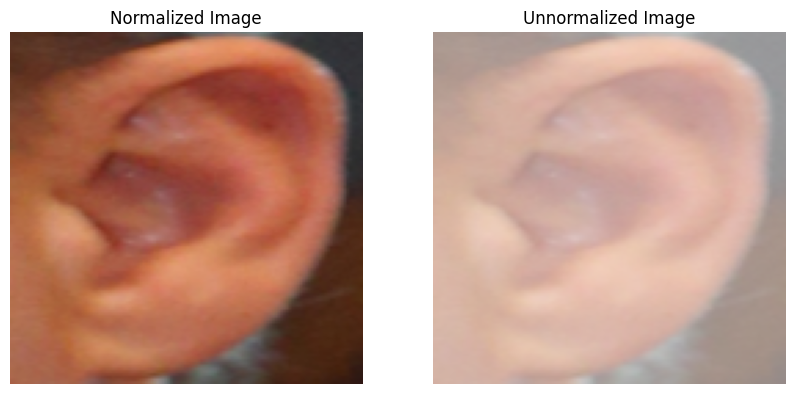

Label: 3


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to denormalize the image
def denormalize(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    # Denormalize image: (img * std) + mean
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return img

# Function to display the image
def imshow(img, title=""):
    img = img / 2 + 0.5  # Reverse normalization for display purposes
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert [C, H, W] to [H, W, C]
    plt.title(title)
    plt.axis('off')

# Get a batch of images from trainloader using the iter() and next() method
dataiter = iter(train_loader)  # Create an iterator
images, labels = next(dataiter)  # Use next() to get a batch

# Select the first image
image = images[0]

# Denormalize the image for unnormalized version
unnormalized_image = denormalize(image)

# Plot both normalized and unnormalized images side by side
plt.figure(figsize=(10, 5))

# Display normalized image
plt.subplot(1, 2, 1)
imshow(image, title="Normalized Image")
print(image.shape)

# Display unnormalized image
plt.subplot(1, 2, 2)
imshow(unnormalized_image, title="Unnormalized Image")

plt.show()

# Print label for reference
print('Label:', labels[0].item())


In [4]:
#################################
#    Class Conditional CFM
#################################

sigma = 0.0
model = UNetModel(
    dim=(3, 128, 128), num_channels=128, num_res_blocks=1, num_classes=100, class_cond=True, use_new_attention_order=True, use_scale_shift_norm=True
).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
# Users can try target FM by changing the above line by
# FM = TargetConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [6]:
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt, y)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="\r")

        # Save model every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_path = f"{savedir}/model_epoch_{epoch+1}.pt"
        torch.save(model.state_dict(), save_path)
        print(f"\nModel saved at epoch {epoch+1} -> {save_path}")

epoch: 9, steps: 31, loss: 1.103
Model saved at epoch 10 -> models/ear/model_epoch_10.pt


In [7]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(1, device=device).repeat(1)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(1, 3, 128, 128, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
'''grid = make_grid(
    traj[-1, :100].view([-1, 3, 128, 128]), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()'''

'grid = make_grid(\n    traj[-1, :100].view([-1, 3, 128, 128]), padding=0, nrow=10\n)\nimg = ToPILImage()(grid)\nplt.imshow(img)\nplt.show()'

In [8]:
traj.shape

torch.Size([2, 1, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6301019..3.1703575].


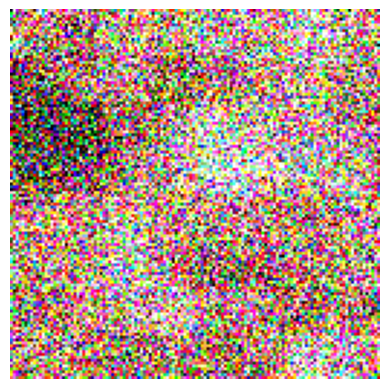

In [9]:
imshow(traj.cpu()[-1,0])